## Rough Agenda

* 00:00 – 00:15 Welcome and introductions
* 00:15 – 00:30 Technical setup in Colab or Jupyter
* 00:30 – 00:55 Introduction to spatial data types
* 00:55 – 01:30 Hands on with spatial data – simple mapping and joins
* 01:30 – 01:45 Coordinate Systems
* 01:45 – 02:00 Break
* 02:00 – 02:45 Rasters and zonal statistics
* 02:45 – 03:15 Putting the pieces together – spatial joins, aggregations, and mapping
* 03:15 – 03:30 Wrap up and further resources 

# Goals and Approach
This tutorial assumes familiarity with tabular data, table joins, and general data science and data structures that research software engineers will, by and large, understand. It will focus on the addition of spatial capabilities to that toolset and intentionally chooses geopandas and related libraries for data processing so as to act as a layer on top of other tools for working with data rather than a whole new suite of concepts. It won't explain concepts like tabular subsets (often called selections in GUI-based GIS tools) in depth, because these are common to data science approaches, but it will explain new capabilities provided by spatial data.

# What is GIS?

I define GIS as:

> Software and data that enable us to ask and answer questions involving where something is and how that location relates to other things.

There’s no reference implementation for GIS – it’s a loose definition for a broad suite of ideas related to spatial needs.


## How is Spatial Data Different?
For most experienced analysts of tabular and image data, spatial data will be familiar, but it provides a few conceptual differences:
1. Tabular fields with spatial information can be connected to other tables by their spatial information leading to new kinds of joins based not on keys, but on *location*, with varied criteria for matching. This is a deeply powerful capability leading to a whole new class of questions and answers
2. Image data - not just visible light images, but also gridded datasets - have geographic referencing allowing them to be overlaid in space with other image or tabular data.

## Spatial Data Questions
* **What exists** at a certain location?
* **Where** (or when) are certain conditions satisfied?
* **What has changed** in a place over time?
* What **spatial patterns** exist?
* **What if** this condition occurred at this place? (modeling, hypothesis testing)
* **Where** do variables interact?
* We can try to answer questions of “why” and “how” too, but they require reformulating the question


# Spatial Data Packages in Python
To start out, let's review a few of our friends in working with spatial data

* **GDAL**: Geospatial Data Abstraction Library - software underlying most of the spatial operations we'll do - you usually don't need to call it directly, but you usually *do* need it installed
* **fiona**: Python package for reading/writing spatial data formats
* **geopandas**: A package that extends Pandas dataframes so that they also have spatial data support (including spatial operations) - crossing data science approaches with spatial information!
* **folium**: A package for making simple maps. We'll use it in this tutorial in order to visualize results of our code within the notebook

# Spatial Data Types

In [ ]:
# Let's start by just showing a basic Leaflet map with none of our own data on it.
# Leaflet maps are simple web maps that can display tile layers - the kind you're used to seeing in most mapping applications as a background

import folium
web_map = folium.Map(location=(37.365, -120.424), zoom_start=16)  # initialize a folium object over UC Merced
# we set its center to a latitude and longitude (note coordinate order. Lat,Lon is roughly Y,X not X,Y
#   - roughly because these are angular coordinates, not cartesian)
# zoom levels are powers of 2, more zoomed in the higher the number

web_map   # show the map in the notebook

# PRACTICE: feel free to adjust the parameters and rerun the cell. If you want to see more options
# Docs for this class are at https://python-visualization.github.io/folium/latest/reference.html#module-folium.folium

# Basic Spatial Data Constructs
*As with many things in this notebook, we're showing it in Python, but trying to focus on concepts that generally are language/system agnostic*

Spatial data comes down to pairs of coordinates that we typically call points. These points can be connected together in many ways and have attributes attached, but the spatial data is typically one or more coordinate pairs. We'll use longitude and latitude here, but it all depends what coordinate system you're using to reference to the Earth. More on that later.

In [ ]:
# What's in a "geometry"?
from shapely import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon

# we're just going to define some points here. Note that these are coordinates in WGS 1984 Longitude
# *specifically note that these are in longitude, Latitude order, but the map we defined above is the reverse. This occassionally trips up
# even experienced mappers because it's easy to not notice the swapped coordinates when it just looks like data isn't displaying.
# It even messed me up while developing this lesson!
ucm_point = Point(-120.424, 37.365)
second_point = Point(-120.4245, 37.364)

marker = folium.Circle(radius=20, fill_color="orange", fill_opacity=0.4, color="black", weight=1) # this is optional - it will style them by default, but it'll make the points more obvious

# convert the points to simple geojson and add them to the map
folium.GeoJson(ucm_point, marker=marker).add_to(web_map)
folium.GeoJson(second_point, marker=marker).add_to(web_map)
web_map  # show the updated map. It'll have anything we added before, along with the new things we're adding now

In [ ]:
# lines work the same way - they just connect all the points you provide in a list
line = LineString([ucm_point, second_point])
folium.GeoJson(line).add_to(web_map)  # add our line to the map
web_map  # and show the map. Note that we can still see the points because we added them previously. It's not a feature of the line we added

# Practice: Try making a new map and adding the line to it to see the line without the point markers. You can copy the code that creates web_map from
# a few cells up.

In [ ]:
# Just making a few more points in the same general vicinity
third_point = Point(-120.4245, 37.363)
fourth_point = Point(-120.424,37.362)

# Make them into a line with more nodes/vertices
points_list = [ucm_point, second_point, third_point, fourth_point]

# lines don't need to be straight, and can have many segments
bent_line = LineString(points_list)
folium.GeoJson(bent_line, marker=marker).add_to(web_map)  # as we can see here
web_map

In [ ]:
# and the difference between a line and a polygon is often that the polygon is "closed" and has area, where the line does not.
# often the difference is only that you say it's a line or a polygon and the underlying GIS interprets the data as a line
# or an area as a result
trapezoidy = Polygon(points_list)
folium.GeoJson(trapezoidy, marker=marker).add_to(web_map)
web_map

# Practice
Feel free to go adjust some of the coordinates, or if you think you'll want to make some Folium maps, [take a look at their documentation on markers for points](https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson_marker.html) and try to change how your points are displayed on the map.

# Describing the Spatial Data
So far, the data we've looked at has had the spatial components of spatial data, but not the tabular or descriptive components. That is, it has a location - as a point, a line, or an area - but nothing that tells us anything about that location. This is where database concepts come into play, because vector data are described by an attribute record that applies to the whole feature, whether point, line, or polygon. The schema of these records is flexible, but most data formats require that you stick to one type of vector data (e.g. only points, only lines, or only polygons), and that they all share the same set of fields/attributes, even if some of the values are null. Attribute tables should feel very familiar to those of you are familiar with databases and data science, where we add the geometry as an attribute with a special set of capabilities.

# Summary of Geometries
Collectively, the types of geometry we've been working with so far are called **vector data** - point locations can be translated, shapes can be scaled and buffered, etc, without losing any information on the **attributes** - the tabular data that is attached to each vector item.

## Enter Geodataframes
<img src="https://geopandas.org/en/stable/_images/dataframe.svg">

via [Geopandas documentation](https://geopandas.org/en/stable/getting_started/introduction.html)


In [ ]:
# Now let's load some data from a web service. California's Natural Resources Agency
# data portal at https://data.cnra.ca.gov has groundwater basin boundaries
import geopandas

# geopandas supports reading local files, but also straight from URLs. Here's data as a zipped shapefile on the web
groundwater_basin_data_shapefile_url = r"https://gis.data.cnra.ca.gov/datasets/bdfc6550b4f3401a83ad1e2f468140ca_0.zip?where=1=1&outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
basins = geopandas.read_file(groundwater_basin_data_shapefile_url)
basins.set_index("Basin_Su_1", drop=False, inplace=True)  # set the index so we can do quick subsets later on
basins.head()


In [ ]:
# Interlude, let's make a quick function that lets us display Geodataframes on the map
# this code is just for illustrating what we are learning elsewhere in the notebook, so it's nice to abstract it away
# note: It's easy to plot geodataframes with matplotlib too, so explore that if you have a preference for that capability.
# See https://geopandas.org/en/stable/docs/user_guide/mapping.html for Geopandas' built-in matplotlib based drawings

# Don't worry too much about what this code is doing yet - just know that it will display our results on a map for us.
# Some of it will make more sense when we get to the *end* of the workshop

def map_geodataframes(dfs, web_map=None):
    if not web_map:  # if they didn't provide a map to use and add the data to, then
        web_map = folium.Map()  # create a folium map

    # if an iterable wasn't passed in, make it an iterable so we can loop over it below
    if isinstance(dfs, geopandas.GeoDataFrame):
        dfs = (dfs,)
    
    for df in dfs:
        # if the df is actually a dict, then we're passing in a df and a layer name, so split them out
        if isinstance(df, dict):
            name = df["name"]
            df = df["df"]
        else: # otherwise, use the name None
            name = None
        
        # if the projection isn't already in WGS 1984 decimal degrees, convert it
        # we'll get to projections in a little bit
        if df.crs.to_epsg() != 4326:
            df = df.to_crs("EPSG:4326")
        
        # convert the data frame to GeoJSON, make a layer, and add it to the map in one go
        folium.GeoJson(df.to_json(), name=name).add_to(web_map)
    
    # add the layer control so we can toggle it while we're at it
    folium.LayerControl().add_to(web_map)

    # zoom to the data we add to the map: https://gis.stackexchange.com/a/393844
    web_map.fit_bounds(web_map.get_bounds(), padding=(30, 30))
    
    return web_map

In [ ]:
web_map = map_geodataframes(basins)
web_map

In [ ]:
# Let's get a more limited subset to work with of just California's central valley.
# we can do this with standard pandas subsetting.

cv_basins = basins.loc[basins["Basin_Name"].isin(["SACRAMENTO VALLEY", "SAN JOAQUIN VALLEY"]),]
cv_basins.head()  # confirm we subset it with a tabular view

In [ ]:
# then confirm it on a map
map_geodataframes(cv_basins)

In [ ]:
# we can make things a bit faster in the future if we *reproject* this data

def reproject_to_wgs84(input):
    if input.crs.to_epsg() != 4326:
        return input.to_crs("EPSG:4326")
    else:
        return cv_basins
        
cv_basins_4326 = reproject_to_wgs84(cv_basins)
map_geodataframes(cv_basins_4326)

In [ ]:
# What about a situation where we don't have a convenient attribute value to subset on? That's where we need to use the spatial data!
cv_boundary = geopandas.read_file("https://water.usgs.gov/GIS/dsdl/pp1766_Alluvial_Bnd.zip")
cv_boundary_4326 = reproject_to_wgs84(cv_boundary)
map_geodataframes(cv_boundary)

## Joining in SPAAAAACCE
So we're going to do something conceptually similar to a join, but instead of matching on a common attribute value like a table join, it's going to match records based on their spatial relationship.

This is one of the most fundamental parts of working with spatial data. Many other operations boil down to a series of steps that are a similar overlay of two types of spatial data.

This is called a Spatial Join (in many different GIS packages) - it's the `.sjoin()` method in GeoPandas



In [ ]:
# note that we *must* make sure the data are in the same projection before doing spatial operations. Some GUI GIS packages
# are smart enough to ensure this for you behind the scenes (helpful and dangerous at the same time!), but many
# code packages won't do this. If you're getting mysterious problems, check your projections.

# note that in the sjoin call, we can specify that it's an inner join to only keep records that match, and that the predicate sets
# the type of spatial relationship
cv_basins_from_spatial = cv_basins_4326.sjoin(cv_boundary_4326, how="inner", predicate="intersects")
map_geodataframes(cv_basins_from_spatial)  # and map it afterward so we know we're getting the same result

# PRACTICE: Try running this cell again with a few different predicates (e.g. "within"). You can find 
# available predicates with print(cv_basins_4326.sindex.valid_query_predicates). What's changing and why?

In [ ]:
# Let's see what types of joins we can do
print(cv_basins_4326.sindex.valid_query_predicates)

In [ ]:
cv_basins_within = cv_basins_4326.sjoin(cv_boundary_4326, how="inner", predicate="within")
cv_basins_overlaps = cv_basins_4326.sjoin(cv_boundary_4326, how="inner", predicate="overlaps")

# we can pass an iterable of dicts that each have a 'df' and a 'name' key to this function to have them all mapped - 
# this isn't some builtin functionality, just how we built our mapping function
map_geodataframes((
    {
        'df': cv_basins_overlaps,
        'name': "Basins - Overlap Method"
    },
    {
        'df': cv_basins_from_spatial,
        'name': "Basins - Intersect Method"
    },
    {
        'df': cv_basins_within,
        'name': "Basins - Within Method"
    },
    {
        'df': cv_boundary,
        'name': "Central Valley Boundary"
    }
))

## Some questions
Look through the results in the map above - toggle only one of the basins layers on at a time and toggle the central valley boundary on and off to see the basins and the boundary separately. Consider why each type of spatial join results in its specific outputs.

Geopandas uses Shapely for these kinds of overlays, and the shapely docs are very thorough. See this section for more information on the various overlay behaviors: https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates

# What about a centroid or interior point approach?
One method I find is often important in spatial joins is to join a point representation of one object to another to determine its membership. Intersects, overlays, etc, can result in a fuzzy match, but a centroid match gives us a better 1:1 assignment that reduces double counting if we plan to do future aggregations.

Centroids are tricky though. Run this code [from the shapely documentation](https://shapely.readthedocs.io/en/stable/manual.html#object.representative_point) to see why:

In [ ]:
import shapely
polygon = shapely.Point(0, 0).buffer(2.0).difference(shapely.Point(0, 0).buffer(1.0))  # create a polygon 
print(polygon.centroid)
print(polygon.representative_point())  # note that this is a method, but centroid is an attribute

In [ ]:
# Why are they different? Let's plot the object to see what it looks like:

# the docs specifically note that this is experimental - not for production, but useful for exploration and debugging
from shapely.plotting import plot_polygon
plot_polygon(polygon)

So, why are they different? Because the centroid of this polygon *is* at 0,0, but the `representative_point` method is guaranteeing that it will create a point within the polygon. For many instances, that's more important, but it doesn't give you a lot of matching control in the context of a spatial join. If you're joining complex data with holes, you may want to use representative_point, but otherwise, might want to stick with the centroid.

PRACTICE: We haven't discussed shapely operations yet, but go back up to where the polygon was created and see if you can figure out how the calls on that line created a donut polygon like this

In [ ]:
# show a folium map of point data, line data, and polygon data

# we'll use LandIQ fields for SJV and overlay them with Groundwater basins, summing up acreage by basin - spatial join the basin
# to the fields, then use geopandas to sum. For zonal stats, we'll aggregate ET to fields or to basins

# Spatial Joins

# Coordinate Systems
Coordinate systems, often called projections as a catch-all, are one of the most important components of working with spatial data, and one that software engineers have worked the hardest to hide from you whenever possible. A very rapid overview:

* The Earth is a sphere (Earth: "I'm not a sphere"), but maps are usually on a flat surfact like a sheet of paper or a computer screen. There are some challenges, tradeoffs, and a bunch of math involved in accurate display of spherical information on a flat surface
* So, yeah, I lied. The Earth isn't a sphere, it's an oblate spheroid - it's like a sphere, but it's squished in one direction, and it's also pretty bumpy. For our purposes, just assume that makes the math harder.

Coordinate systems help us reference data on such a surface - whether that's coordinates on a spherical surface or on a planar projection of that surface.

We can see that *something* won't translate directly when we consider that the coordinates we have for the globe aren't planar X,Y coordinates - they're angular coordinates - so, traveling a distance in degrees isn't always the same distance in meters - it depends on your latitude! Near the poles, you can travel a few degrees in a short linear distance while near the equator it's thousands of kilometers.

To convert angular data to planar surfaces, we project the data. Conceptually, it gains a second coordinate system in doing so - it still keeps its underlying longitude, latitude based coordinates, but then adds X, Y coordinate mapping to that for display on flat surfaces.


## Properties that Projections Preserve or Distort

* Area
	* “Equivalent” projections
* Distance
	* “Equidistant” projections
* Direction (Angle)
	* “Conformal” projections
* Form (shape)
* Scale

## Common Projections and Examples for Global Use
### Equirectangular

<a title="Strebe, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Equirectangular_projection_SW.jpg"><img width="768" alt="Equirectangular projection SW" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Equirectangular_projection_SW.jpg/1024px-Equirectangular_projection_SW.jpg"></a>

* Equal, constant distances between parallels and meridians - e.g. treat lon as X and lat as Y. Math is simple!
* Usually how data stored in a Geographic Coordinate System (GCS) is displayed by default since it *must* be projected to be displayed

### Mercator
<a title="Strebe, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Mercator_projection_SW.jpg"><img width="768" alt="Mercator projection SW" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Mercator_projection_SW.jpg/1024px-Mercator_projection_SW.jpg"></a>

* Angles preserved
* Good for navigation
* A variation optimized for calculation speed is the de facto standard for web mapping

### Mollweide
<a title="Strebe, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Mollweide_projection_SW.jpg"><img width="768" alt="Mollweide projection SW" src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Mollweide_projection_SW.jpg/1024px-Mollweide_projection_SW.jpg"></a>

* Relative areas preserved
* Shape distorted

### Universal Transverse Mercator
<a title="Chrismurf at English Wikipedia, CC BY 3.0 &lt;https://creativecommons.org/licenses/by/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Utm-zones-USA.svg"><img width="768" alt="Utm-zones-USA" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Utm-zones-USA.svg/1024px-Utm-zones-USA.svg.png"></a>

* Specialized application of the Transverse Mercator projection developed by US ACE 1940
* 60 north and south zones, spanning 6°of longitude
	* Origin of each zone is its central meridian and the equator
	* False Eastings and Northings to eliminate negative coordinates
* Shape – Conformal. Accurate representation of small shapes. Minimal distortion of larger shapes within the zone
* Area – Minimal distortion within each UTM zone
* Direction – Local angles are true
* Distance – Scale is constant along the central meridian

### State Plane
[Via CDFW Projection and Datum Guidelines 2018.02](https://nrm.dfg.ca.gov/FileHandler.ashx?DocumentID=109326&inline)
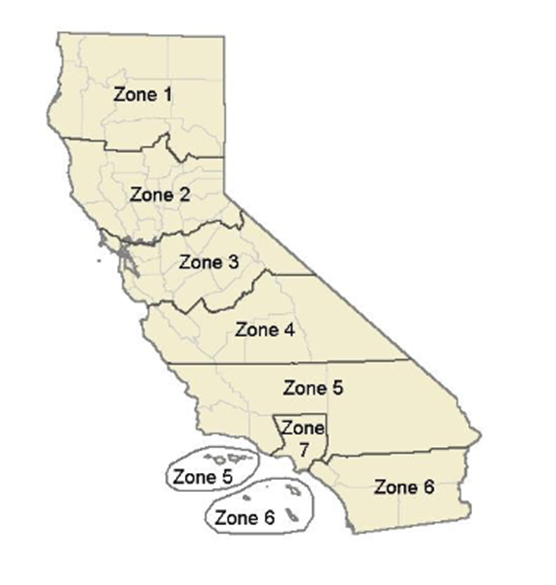

* Coordinate system NOT projection
* Designed for large-scale mapping in the US 
* FIPS standard: 1:10,000 precision
* Feet or meters available
* Each state has 1 to several zones
	* Zones follow county lines
* In CA, we use Lambert Conformal Conic Projection
	* Standard Parallels
	* Best performance near Standard Parallels
	* No loss of accuracy along any Parallel

## Working with Projections





## Further Reading on Projections
https://ubc-library-rc.github.io/map-projections/content/choosing-projection.html

# Raster Data
Raster data is not about point locations, but about pixels - the same as other image concepts you may have worked with. Pixels offer a grid of values, where the value applies to the whole area, but unlike vector data, we can't translate the spatial information while preserving the value as-is. This makes things like reprojections lossy to data, and they should be avoided whenever possible.

# Raster to Vector Joins -> Zonal Statistics!

# Putting the pieces together – spatial joins, aggregations, and mapping

# Spatial Data Formats

## Widely used
### Vector Formats
* **Geopackages** - SQLite DB with special metadata and structures for storing spatial data. Primarily an interchange format. I recommend using these to send and receive data to others as they have wide support in both FOSS and proprietary spatial data systems and are a modern format.
* **Shapefiles** - Old format, but has a published specification, so widely supported. You can assume anyone can open one of these, but they might make changes to your data due to limitations of the format.
* **Geodatabases** - Primarily an Esri term - refers to a few technologies, but most notably "File Geodatabases" - a proprietary format that's challenging to use in many contexts, but often the best choice when using Esri software like ArcGIS.
* **Spatialite** - SQLite DB that can be operated on with spatial operations using special drivers

### Raster Formats
* **GeoTIFFs** - Geographic extensions for metadata and referencing to one of the most widely used and flexible image formats. Widely used and supported - I recommend using them unless the software you're working with has a preference for something else. The [Cloud-Optimized GeoTIFF](https://guide.cloudnativegeo.org/cloud-optimized-geotiffs/intro.html) variant structures the file to allow arbitrary retrievals of portions of files for use in analysis.
* **NetCDF/HDF** - It lives on for multidimensional data and is in wide use. Support for reading/writing it within GUI spatial tools or the Python ecosystem is mixed. See Zarr files below for an alternative for multidimensional gridded data

### Server-based
* **PostGIS** - PostgreSQL extensions in wide use and with broad community support for storing and querying spatial data within the database. Best for vector/tabular data, but can also do operations with raster data. An easy choice if you're looking for a spatially-enabled FOSS database - it's best in class. Requires special licensing and setup to load data from PostGIS into Esri products, but otherwise has wide support.
* **Oracle** also has a spatial data product, and **MySQL** has spatial extensions - I don't know anything about either one.

## Upcoming Formats
Look out for these formats soon - they aim to solve challenges with existing formats, especially with distributed computing of spatial data stored in object storage rather than on a local filesystem.

* [**Zarr**](https://guide.cloudnativegeo.org/zarr/intro.html) - A newish format for gridded, large-scale, multidimensional data.
* [**Geoparquet**](https://guide.cloudnativegeo.org/geoparquet/) - Extends parquet, a storage format for queryable columnar data, 

# Further Resources
## Other tutorials
Here are some additional tutorials and resources that may be useful as points of reference:

1. [Data Carpentry's Geospatial Workshop](https://datacarpentry.org/geospatial-workshop/)

## Other GIS tools
GIS is often conflated with specific systems or types of implementations, but it's really about spatial information broadly and the systems that help us work with it. We've shown a set of Python packages here that are one way to work with spatial data - used in this case because their ability to work with notebooks that run in the cloud make setup a snap for workshop environments. But, like so many other tools, we use them when they're right for the job - keep using them if they're right for you.

If you keep learning or working with spatial data, you might also want to know about two GUI-based GIS tools:

1. [QGIS](https://qgis.org/en/site/) - the top free and open source GUI-based GIS tool today. Great for exploring and analyzing data.
2. [ArcGIS](https://www.esri.com/en-us/home) - the top commercial GIS tool. If you work for a university, they frequently have a site license because Esri wants to train people to use their software. Advantages come if you like their UI and/or if you want ready workflows for publishing and working with data in web maps.

## Package Documentation
1. [Geopandas](https://geopandas.org/en/latest/docs/)
2. [Folium](https://python-visualization.github.io/folium/latest/)
3. [Shapely - Spatial operations in Python](https://shapely.readthedocs.io/en/stable/)
4. [rasterstats](https://pythonhosted.org/rasterstats/)
5. [rasterio](https://rasterio.readthedocs.io/en/latest/index.html)
6. [Fiona](https://fiona.readthedocs.io/en/stable/)

## Housekeeping and installations
First, some housekeeping. On linux/mac machines, dependencies are easy to build, but on Windows machines, things get weird quickly.

For this notebook, we'll make sure it runs fine in the binder environment (yay!), but we want you to have some notes so that you don't throw your computer out the window the first time you try to apply what you've learned outside of the notebook.

Anaconda/conda environments are often a solution, but I've seen `geopandas` break conda environments (entirely) as often as I've successfully installed it, so I recommend a different approach. Use your preferred environment manager, and install the wheels directly from Christopher Gohlke, who builds current wheels for current Python versions of common spatial software, after which it's safe to `pip install` geopandas.

### Linux/Mac
Here's what that looks like. On Linux/Mac, `python -m pip install geopandas` should get you the whole stack, though you may need to install some system packages for gdal (gdal-bin, gdal-dev) first.

If you want to use geopandas on one of these environments though, you should be safe to take a look at both the:
1. [`gdal` installation instructions](https://pypi.org/project/GDAL/) and
2. the [`geopandas` installation instructions](https://geopandas.org/en/stable/getting_started/install.html)

### On Windows



All of that is subject to change - these aren't definitive, but are meant to give you a spot to start after this workshop. The spatial python ecosystem is dispersed, so you're not stuck trying to work with geopandas, but it's powerful and may work well with many workflows RSEs already use.

https://github.com/nickrsan/spatial_resources/blob/main/installing_spatial_python_windows.md